# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
%%javascript
var fname = document.body.attributes['data-notebook-name'].value
var fpath = document.body.attributes['data-notebook-path'].value.replace(/^local/, '/root').replace(fname, '')
IPython.notebook.kernel.execute("theNoteBookDir = '" + fpath + "'" );

<IPython.core.display.Javascript object>

In [2]:
import os
os.getcwd()
os.chdir(theNoteBookDir)

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [17]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.435810
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*

10개의 class이므로 임의의 W로 초기화 했을 때, softmax 함수를 적용한 값이 약 0.1이 됨.
따라서 cross entropy는 -log(0.1)

In [23]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.204799 analytic: -0.204799, relative error: 5.540323e-09
numerical: 0.243720 analytic: 0.243719, relative error: 5.358117e-07
numerical: -2.516719 analytic: -2.516719, relative error: 6.430890e-09
numerical: -1.824317 analytic: -1.824317, relative error: 4.933128e-11
numerical: 1.337975 analytic: 1.337975, relative error: 1.115434e-08
numerical: -2.292400 analytic: -2.292400, relative error: 1.695370e-09
numerical: -0.265336 analytic: -0.265336, relative error: 7.573711e-08
numerical: 4.580008 analytic: 4.580008, relative error: 6.351856e-09
numerical: 1.170493 analytic: 1.170492, relative error: 6.636614e-08
numerical: -0.903867 analytic: -0.903867, relative error: 1.305938e-08
numerical: 6.713326 analytic: 6.713326, relative error: 1.279601e-08
numerical: 1.901171 analytic: 1.901170, relative error: 1.316003e-08
numerical: -0.815755 analytic: -0.815755, relative error: 9.279278e-09
numerical: -1.180042 analytic: -1.180042, relative error: 2.507025e-09
numerical: 3.11881

In [29]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.435810e+00 computed in 0.114641s
vectorized loss: 2.435810e+00 computed in 0.013088s
Loss difference: 0.000000
Gradient difference: 0.000000


In [48]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

top_n = 5

exp_lr_min = -8
exp_lr_max = -6
exp_rs_min = 3
exp_rs_max = 5
for _ in xrange(5):
    results = {}
    for _ in xrange(10):
        exp_lr = np.random.uniform(exp_lr_min, exp_lr_max)
        exp_rs = np.random.uniform(exp_rs_min, exp_rs_max)
        lr = 10 ** exp_lr
        rs = 10 ** exp_rs
        
        softmax = Softmax()
        softmax.train(X_train, y_train, lr, rs, num_iters=1500)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results[(exp_lr, exp_rs)] = (val_accuracy, train_accuracy)
        # print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, rs, train_accuracy, val_accuracy)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_softmax = softmax
            
    print '=========================================================================='
    print ' intermediate result: '
    top_n_results = sorted(results, key=results.get, reverse=True)[0:top_n]
    for exp_lr, exp_rs in sorted(top_n_results):
        val_accuracy, train_accuracy = results[(exp_lr, exp_rs)]
        print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (10**exp_lr, 10**exp_rs, train_accuracy, val_accuracy)
        results[(exp_lr, exp_rs)] = (val_accuracy, train_accuracy)
    
    exp_lr_min = min({k[0] for k in top_n_results})
    exp_lr_max = max({k[0] for k in top_n_results})
    exp_rs_min = min({k[1] for k in top_n_results})
    exp_rs_max = max({k[1] for k in top_n_results})
    print 'new exp_lr (%e, %e) new exp_rs (%e, %e)' % (exp_lr_min, exp_lr_max, exp_rs_min, exp_rs_max)

    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
print '=========================================================================='
print ' result: '
for exp_lr, exp_rs in sorted(results):
    val_accuracy, train_accuracy = results[(exp_lr, exp_rs)]
    print 'train accuracy: %f val accuracy: %f lr %e reg %e ' % (
                train_accuracy, val_accuracy, 10**exp_lr, 10**exp_rs)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

"""
for lr in learning_rates:
    for rs in regularization_strengths:
        #print 'begin lr %e reg %e' % (lr, rs)
        softmax = Softmax()
        softmax.train(X_train, y_train, lr, rs, num_iters=1500)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, rs)] = (train_accuracy, val_accuracy)
        print 'end lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, rs, train_accuracy, val_accuracy)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val
"""

 intermediate result: 
lr 1.727509e-07 reg 4.318044e+03 train accuracy: 0.337592 val accuracy: 0.339000
lr 2.542162e-07 reg 2.204920e+04 train accuracy: 0.355061 val accuracy: 0.369000
lr 3.445668e-07 reg 4.074888e+04 train accuracy: 0.334796 val accuracy: 0.349000
lr 7.292240e-07 reg 7.058005e+03 train accuracy: 0.379245 val accuracy: 0.391000
lr 9.103882e-07 reg 3.286017e+04 train accuracy: 0.322612 val accuracy: 0.338000
new exp_lr (-6.762580e+00, -6.040773e+00) new exp_rs (3.635287e+00, 4.610116e+00)
 intermediate result: 
lr 2.074388e-07 reg 1.369874e+04 train accuracy: 0.365980 val accuracy: 0.388000
lr 2.394976e-07 reg 1.471841e+04 train accuracy: 0.363776 val accuracy: 0.380000
lr 3.907818e-07 reg 5.392145e+03 train accuracy: 0.386122 val accuracy: 0.388000
lr 4.865238e-07 reg 6.635104e+03 train accuracy: 0.384286 val accuracy: 0.398000
lr 8.559319e-07 reg 6.718652e+03 train accuracy: 0.377673 val accuracy: 0.382000
new exp_lr (-6.683110e+00, -6.067561e+00) new exp_rs (3.731762

"\nfor lr in learning_rates:\n    for rs in regularization_strengths:\n        #print 'begin lr %e reg %e' % (lr, rs)\n        softmax = Softmax()\n        softmax.train(X_train, y_train, lr, rs, num_iters=3000)\n        y_train_pred = softmax.predict(X_train)\n        y_val_pred = softmax.predict(X_val)\n        train_accuracy = np.mean(y_train == y_train_pred)\n        val_accuracy = np.mean(y_val == y_val_pred)\n        results[(lr, rs)] = (train_accuracy, val_accuracy)\n        print 'end lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, rs, train_accuracy, val_accuracy)\n        if best_val < val_accuracy:\n            best_val = val_accuracy\n            best_softmax = softmax\n################################################################################\n#                              END OF YOUR CODE                                #\n################################################################################\n    \n# Print out results.\nfor lr, reg in sorted(resu

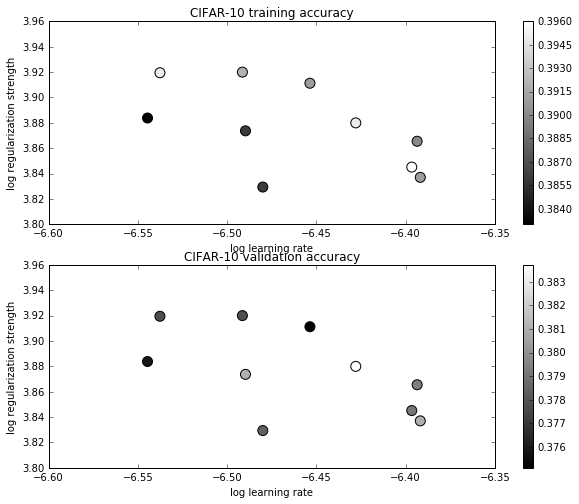

In [49]:
# Visualize the cross-validation results
import math
#x_scatter = [math.log10(x[0]) for x in results]
#y_scatter = [math.log10(x[1]) for x in results]

x_scatter = [x[0] for x in results]
y_scatter = [x[1] for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [50]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

y_val_pred = best_softmax.predict(X_val)
val_accuracy = np.mean(y_val == y_val_pred)
print 'softmax on raw pixels final val set accuracy: %f' % (val_accuracy, )

softmax on raw pixels final test set accuracy: 0.376000
softmax on raw pixels final val set accuracy: 0.400000


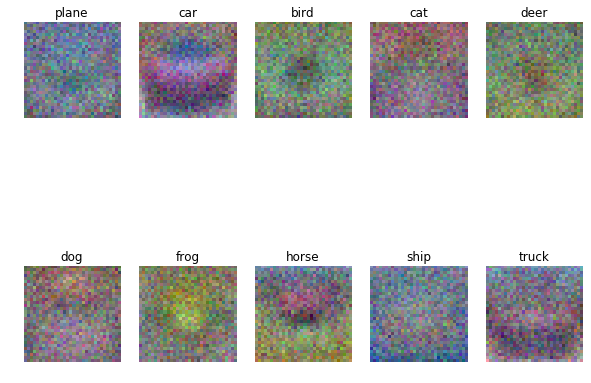

In [51]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])